**<h1><center>Forest Fire Prediction</center></h1>**
<center>Akshaya Mahesh, 
Sakthi Kripa Selvam, 
Manasa Krishnan</center> 



## 1. Dataset Loading
## 2. EDA
## 3. Dataset Preprocessing
## 4. Baseline model

### Importing required Libraries

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

## 1. Dataset Loading

In [3]:
df=pd.read_csv("forestfires.csv")
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
# Shape of the dataset - Dataset has 517 records and 13 columns
df.shape 

(517, 13)

In [5]:
# Looking at the column types and detecting nulls if any
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


There do not seem to be any nulls. We hae float and integer type columns

In [6]:
# Descriptive statistics of the dataset
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


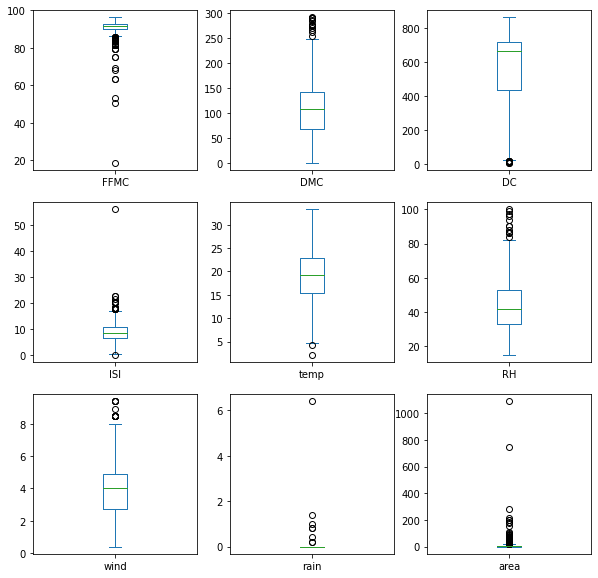

In [7]:
plt.figure(figsize=(10,10))

plt.subplot(3, 3, 1)
df['FFMC'].plot(kind='box')

plt.subplot(3, 3, 2)
df['DMC'].plot(kind='box')

plt.subplot(3, 3, 3)
df['DC'].plot(kind='box')

plt.subplot(3, 3, 4)
df['ISI'].plot(kind='box')

plt.subplot(3, 3, 5)
df['temp'].plot(kind='box')

plt.subplot(3, 3, 6)
df['RH'].plot(kind='box')

plt.subplot(3, 3, 7)
df['wind'].plot(kind='box')

plt.subplot(3, 3, 8)
df['rain'].plot(kind='box')

plt.subplot(3, 3, 9)
df['area'].plot(kind='box')

plt.show()

We looked at the mean, std, minimum, maximum and quartile information of all the features. Rain and Area seemed to have majority of the data centered around 0. Some columns like FFMC and ISI seem to show skewness. 

In [8]:
# Unique months 
df['month'].unique()

array(['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
       'dec', 'may', 'nov'], dtype=object)

In [9]:
# Unique days
df['day'].unique()

array(['fri', 'tue', 'sat', 'sun', 'mon', 'wed', 'thu'], dtype=object)

## 2. EDA

The main goal of our project is to predict the area of forest that could be affected based on some conditions. Therefore, let us visualize the `area` variable.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


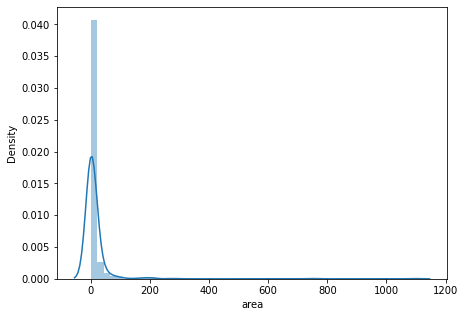

In [10]:
# Skewness of the Area in the dataset
plt.rcParams['figure.figsize'] = [7, 5]
sns.distplot(df['area']);

Let us vizualize few more features to understand the dataset better.

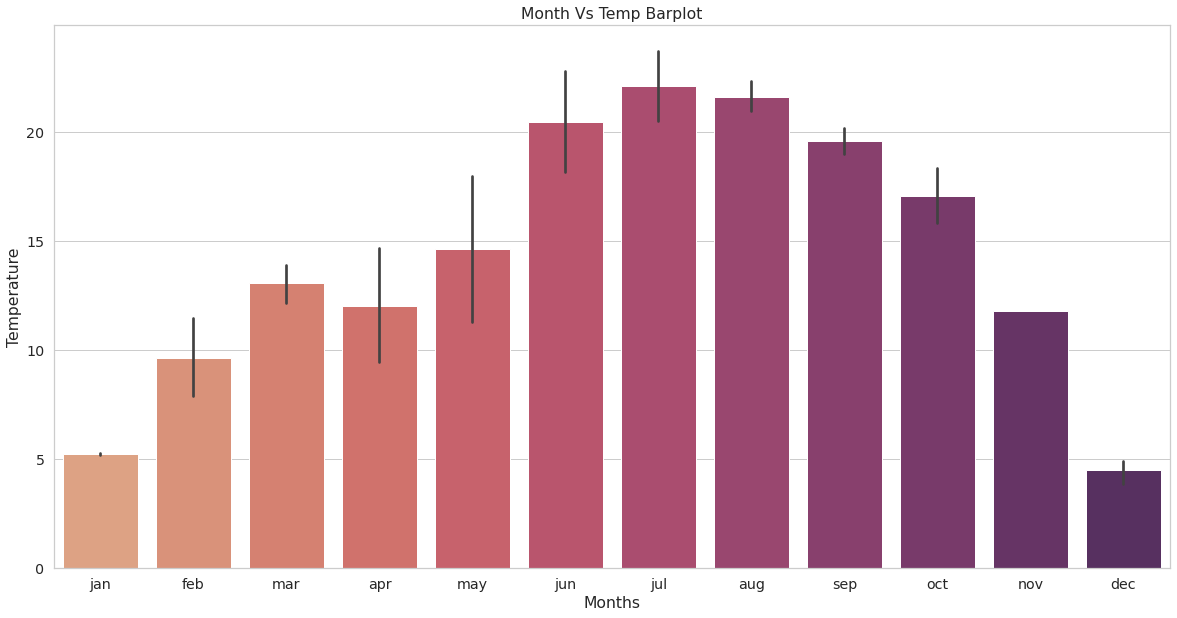

In [11]:
# Month vs Temp
plt.rcParams['figure.figsize'] = [20, 10]
sns.set(style = "whitegrid", font_scale = 1.3)
month_temp = sns.barplot(x = 'month', y = 'temp', data = df,
                         order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                                  'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                         palette = 'flare');
month_temp.set(title = "Month Vs Temp Barplot", xlabel = "Months", 
               ylabel = "Temperature");

The given forest has higher temperatures during summer as expected.

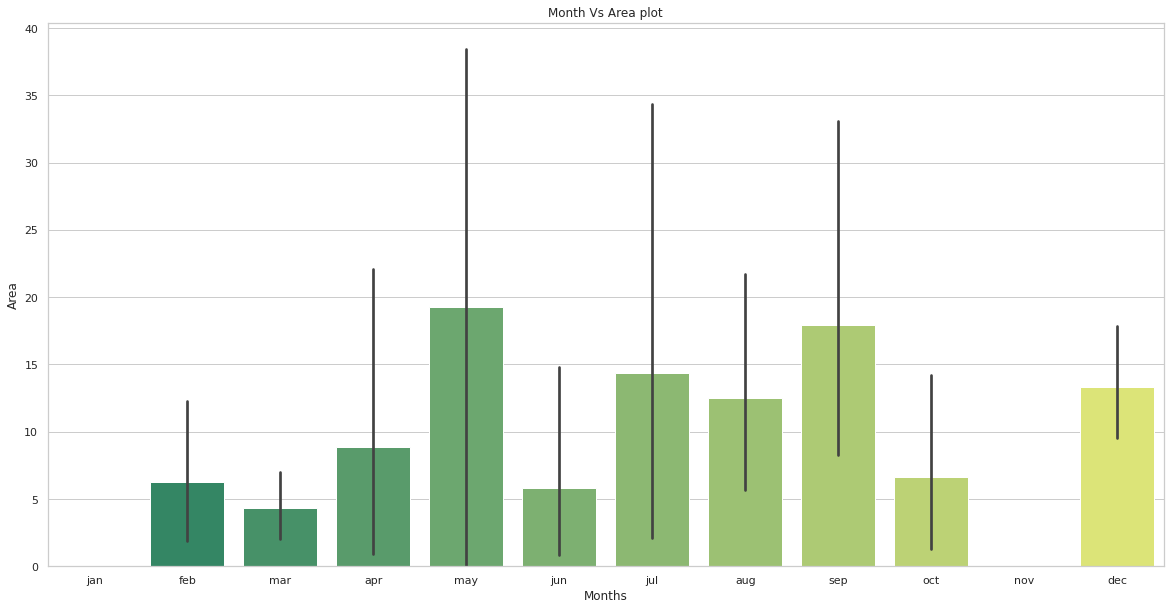

In [12]:
# Month vs Area
plt.rcParams['figure.figsize'] = [20, 10]
sns.set(style = "whitegrid", font_scale = 1.0)
month_vs_area = sns.barplot(x = 'month', y = 'area', data = df,
                         order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                                  'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], 
                            palette = 'summer');
month_vs_area.set(title = "Month Vs Area plot", xlabel = "Months", 
                  ylabel = "Area");

From the above Month Vs Area graph we can see that lot of forest area gets affected during Summer when compared to other seasons. This might be due to high temperatures and dry conditions.</br>
December month also shows significance loss in forest cover area and is something that we need to look into.

Few of the factors that influences occurence of forest fires are Wind and Rainfall. Let us visualize `rain` vs `month` followed by `wind` vs `month`

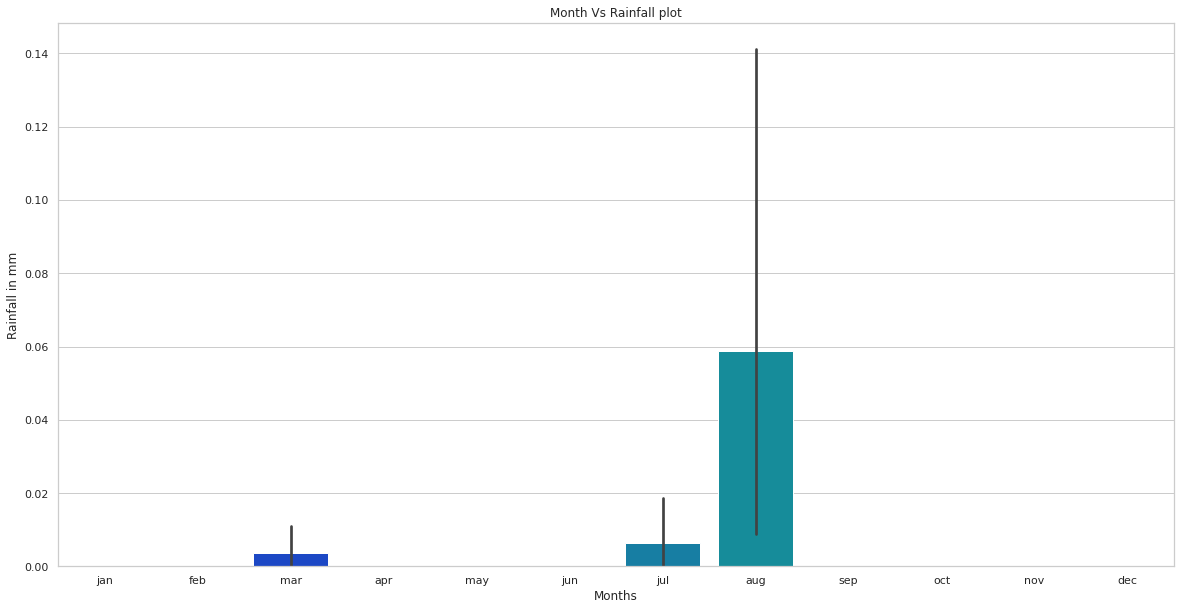

In [13]:
# Month vs Rainfall
plt.rcParams['figure.figsize'] = [20, 10]
sns.set(style = "whitegrid", font_scale = 1.0)
month_vs_rain = sns.barplot(x = 'month', y = 'rain', data = df,
                         order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                                  'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], 
                            palette = 'winter');
month_vs_rain.set(title = "Month Vs Rainfall plot", xlabel = "Months", 
                  ylabel = "Rainfall in mm");

From the above plot we can see that most of the months do not have rainfall. Though August has the most rainfall, it is worth noting that the forest gets significantly affected during this month from the above month vs area plot.

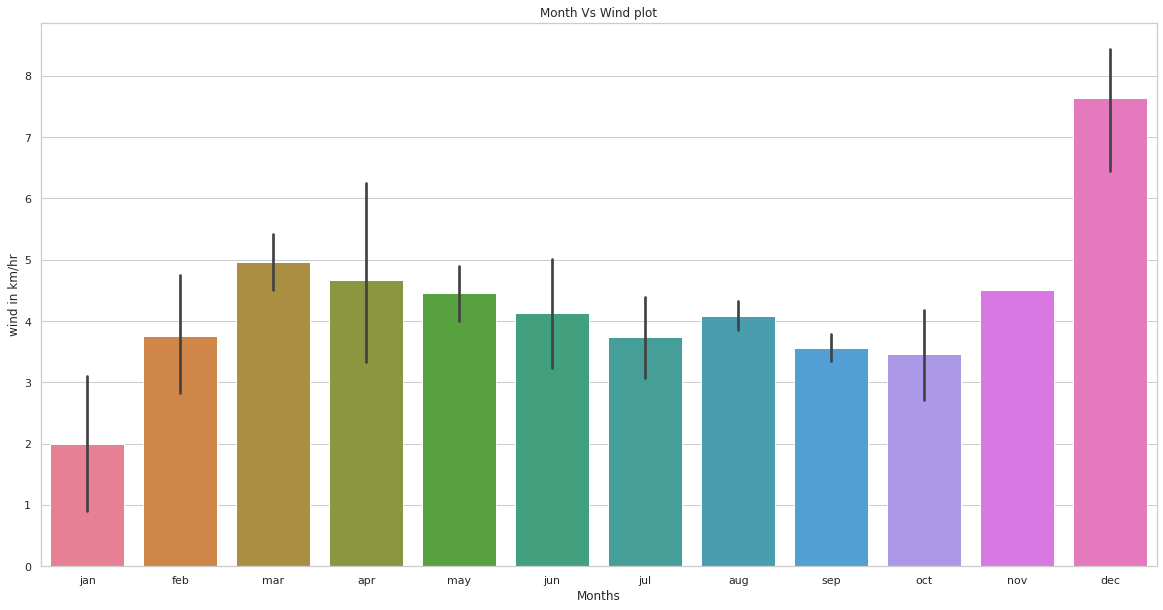

In [14]:
# Month vs Wind
plt.rcParams['figure.figsize'] = [20, 10]
sns.set(style = "whitegrid", font_scale = 1.0)
month_vs_wind = sns.barplot(x = 'month', y = 'wind', data = df,
                         order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                                  'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], 
                            palette = 'husl');
month_vs_wind.set(title = "Month Vs Wind plot", xlabel = "Months", 
                  ylabel = "wind in km/hr");

From the above plot we can see that the forest experiences winds between 3-5 km/hr for most of the months. Though the months May and Nov have approximately same wind speeds, the forest loses a signinficant amount of its area during May compared to Nov. This tells us that there are other factors that greatly influence Forest fires.</br>
The Forest seems to experience higher winds in December and area affected by forest fire is also significant.

Text(0, 0.5, 'Area in Hectare')

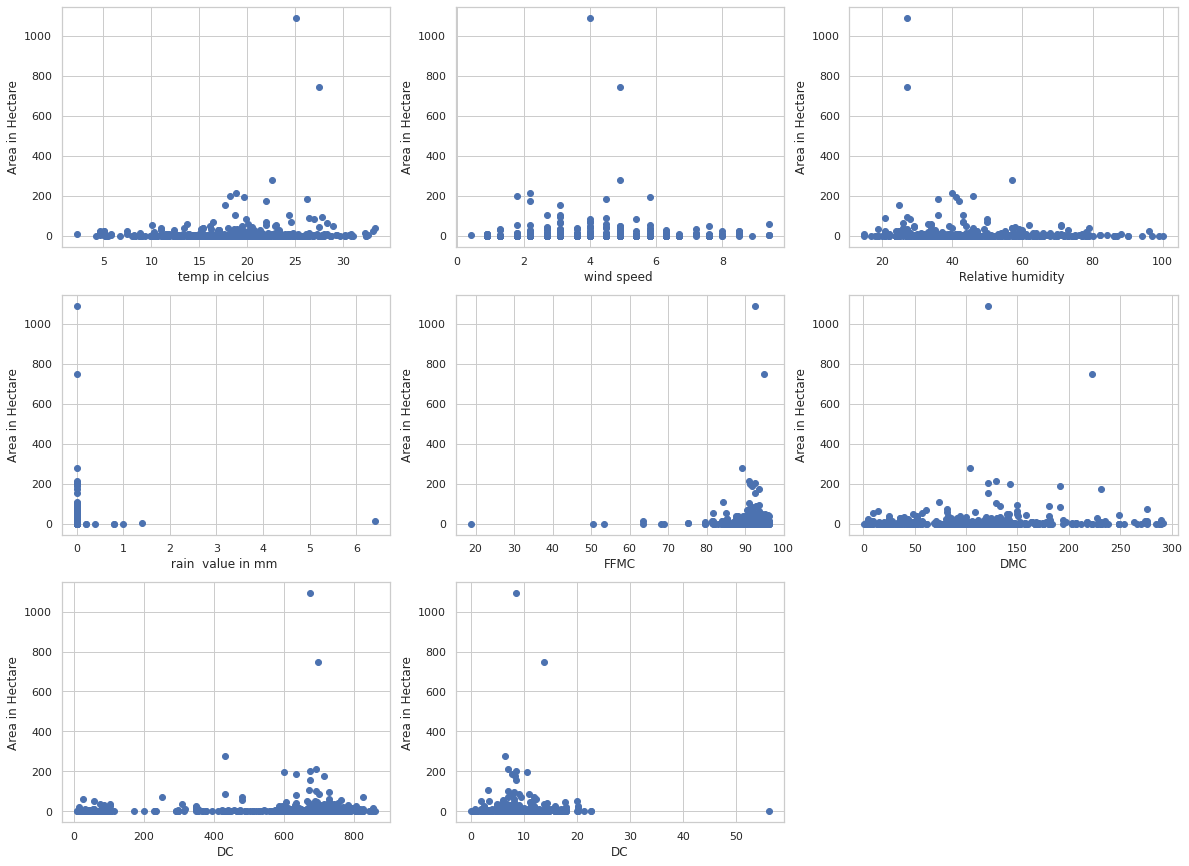

In [15]:
# Scatter Plots
plt.figure(figsize=(20,15))

plt.subplot(3,3,1)
plt.scatter(x=df["temp"],y=df["area"])
plt.xlabel(" temp in celcius  ")
plt.ylabel("Area in Hectare")

plt.subplot(3,3,2)
plt.scatter(x=df["wind"],y=df["area"])
plt.xlabel(" wind speed  ")
plt.ylabel("Area in Hectare")

plt.subplot(3,3,3)
plt.scatter(x=df["RH"],y=df["area"])
plt.xlabel(" Relative humidity  ")
plt.ylabel("Area in Hectare")

plt.subplot(3,3,4)
plt.scatter(x=df["rain"],y=df["area"])
plt.xlabel(" rain  value in mm  ")
plt.ylabel("Area in Hectare")

plt.subplot(3,3,5)
plt.scatter(x=df["FFMC"],y=df["area"])
plt.xlabel("FFMC")
plt.ylabel("Area in Hectare")

plt.subplot(3,3,6)
plt.scatter(x=df["DMC"],y=df["area"])
plt.xlabel("DMC")
plt.ylabel("Area in Hectare")

plt.subplot(3,3,7)
plt.scatter(x=df["DC"],y=df["area"])
plt.xlabel("DC")
plt.ylabel("Area in Hectare")

plt.subplot(3,3,8)
plt.scatter(x=df["ISI"],y=df["area"])
plt.xlabel("DC")
plt.ylabel("Area in Hectare")

From the above scatter plot visualization, it can be seen none of features seem to vary linearly with the predictor variable. 

## 3. Data Preprocessing

In [16]:
# Checking for skewness in the predictor variable
df.skew(axis = 0)

<ipython-input-16-573d5307443c>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew(axis = 0)


X        0.036246
Y        0.417296
FFMC    -6.575606
DMC      0.547498
DC      -1.100445
ISI      2.536325
temp    -0.331172
RH       0.862904
wind     0.571001
rain    19.816344
area    12.846934
dtype: float64

In [17]:
# Correcting the skewness in the response variable
df_unclean = df.copy()
df['area'] = np.log(df['area'] + 1)
print("Previous skew of area:", df_unclean['area'].skew())
print("Current skew of area:", df['area'].skew())

Previous skew of area: 12.846933533934868
Current skew of area: 1.2178376559535011


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'After applying log')]

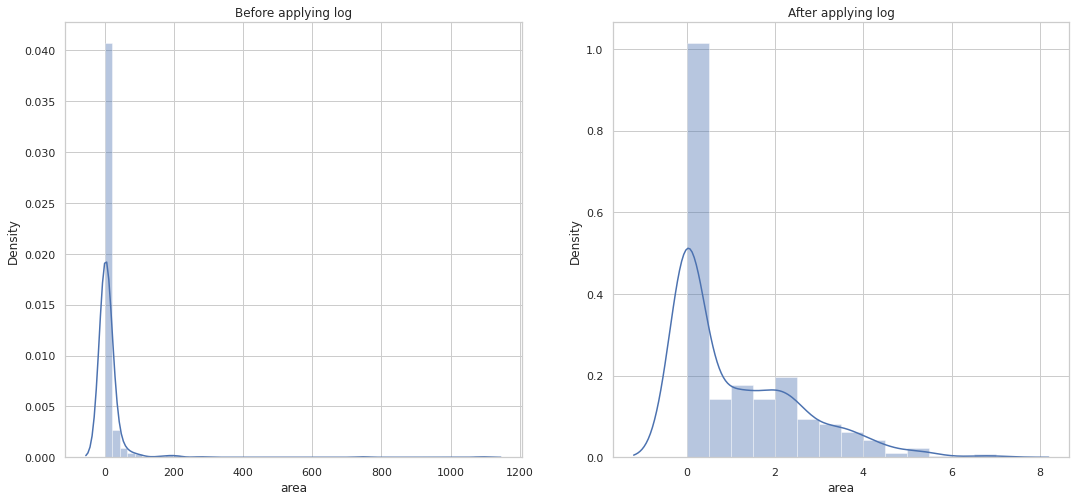

In [18]:
# Plotting skewness of the response variable before and after preprocessing

plt.rcParams['figure.figsize'] = [18, 8]
fig, ax = plt.subplots(1, 2)

plot1 = sns.distplot(df_unclean['area'], ax = ax[0])
plot1.set(title = 'Before applying log')
plot2 = sns.distplot(df['area'], ax = ax[1])
plot2.set(title = 'After applying log')

In [19]:
# Normalizing the FWI and other climatic factors
normalizer = MinMaxScaler()
FFMC_transform = np.array(df['FFMC']).reshape(-1, 1)
DMC_transform = np.array(df['DMC']).reshape(-1, 1)
DC_transform = np.array(df['DC']).reshape(-1, 1)
ISI_transform = np.array(df['ISI']).reshape(-1, 1)
temp_transform = np.array(df['temp']).reshape(-1, 1)
RH_transform = np.array(df['RH']).reshape(-1, 1)
wind_transform = np.array(df['wind']).reshape(-1, 1)
rain_transform = np.array(df['rain']).reshape(-1, 1)

df['FFMC'] = normalizer.fit_transform(FFMC_transform)
df['DMC'] = normalizer.fit_transform(DMC_transform)
df['DC'] = normalizer.fit_transform(DC_transform)
df['ISI'] = normalizer.fit_transform(ISI_transform)
df['temp'] = normalizer.fit_transform(temp_transform)
df['RH'] = normalizer.fit_transform(RH_transform)
df['wind'] = normalizer.fit_transform(wind_transform)
df['rain'] = normalizer.fit_transform(rain_transform)

In [20]:
# Converting categorical values to numerical values

df['month'] = df['month'].replace(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                                   'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], 
                                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
df['day'] = df['day'].replace(['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat'],
                              [1, 2, 3, 4, 5, 6, 7])
print("The dataset after cleaning:") 
df.head()

The dataset after cleaning:


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,6,0.870968,0.086492,0.101325,0.090909,0.192926,0.423529,0.700000,0.00000,0.0
1,7,4,10,3,0.927742,0.118194,0.775419,0.119430,0.508039,0.211765,0.055556,0.00000,0.0
2,7,4,10,7,0.927742,0.146795,0.796294,0.119430,0.398714,0.211765,0.100000,0.00000,0.0
3,8,6,3,6,0.941935,0.110958,0.081623,0.160428,0.196141,0.964706,0.400000,0.03125,0.0
4,8,6,3,1,0.910968,0.172984,0.110590,0.171123,0.295820,0.988235,0.155556,0.00000,0.0


In [21]:
# Splitting the dataset into train and test

X = df.drop(columns = ['area'])
y = df['area']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [22]:
# Printing the shapes of the train and test datasets

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (413, 12)
y_train: (413,)
X_test: (104, 12)
y_test: (104,)


## 4. Baseline Model

In [23]:
# Implementing linear regression model

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [24]:
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)
train_rmse = math.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)
test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
print("The train rmse using linear regression:", round(train_rmse, 3))
print("The train r2 score using linear regression:", round(train_r2, 3))
print("The test rmse using linear regression:", round(test_rmse, 3))
print("The test r2 score using linear regression:", round(test_r2, 3))

The train rmse using linear regression: 1.35
The train r2 score using linear regression: 0.035
The test rmse using linear regression: 1.467
The test r2 score using linear regression: 0.021


In [25]:
# Implementing Lasso Regression

ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [26]:
train_preds = ridge.predict(X_train)
test_preds = ridge.predict(X_test)
train_rmse = math.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)
test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
print("The train rmse using lasso regression:", round(train_rmse, 3))
print("The train r2 score using lasso regression:", round(train_r2, 3))
print("The test rmse using lasso regression:", round(test_rmse, 3))
print("The test r2 score using lasso regression:", round(test_r2, 3))

The train rmse using lasso regression: 1.351
The train r2 score using lasso regression: 0.033
The test rmse using lasso regression: 1.463
The test r2 score using lasso regression: 0.026


# Results

After obtaining clarification of the problem at hand to some extent with data cleaning and EDA, we proceeded forward with creating 2 baseline models. The results of those models are:

1. Linear regression - RMSE: 1.467, R2: 0.021
2. Ridge regression - RMSE: 1.463, R2: 0.026

The reasons behind the models performing like they do can be:

1. Outliers and 0 area - The data has a couple of outliers which we will look more into and decide the kind of step we have to take to manipulate/remove them. Some values indicate that there is no forest fire(area of 0), which is acceptable, but we have to find a way to improve our method of scaling/normalization to match other outcomes.

2. Simplistic models - The models chosen here are meant to be simplistic as they are baseline. We hope to achieve improved results with more complex models with which we have control over model parameters.

## 5. XGBoost

In [46]:
# Base model without tuning parameters
xg_reg = xgb.XGBRegressor()

In [47]:
xg_reg.fit(X_train, y_train)

[23:16:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [48]:
# Train and test model performance
train_preds = xg_reg.predict(X_train)
test_preds = xg_reg.predict(X_test)
train_rmse = math.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)
test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
print("The train rmse using XGBoost regression:", round(train_rmse, 3))
print("The train r2 score using XGBoost regression:", round(train_r2, 3))
print("The test rmse using XGBoost regression:", round(test_rmse, 3))
print("The test r2 score using XGBoost regression:", round(test_r2, 3))

The train rmse using XGBoost regression: 0.939
The train r2 score using XGBoost regression: 0.534
The test rmse using XGBoost regression: 1.561
The test r2 score using XGBoost regression: -0.109


In [49]:
# Grid Search CV to tune parameters
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7, 8],
              'min_child_weight': [1, 2, 3, 4],
              'subsample': [0.5, 0.6, 0.7],
              'colsample_bytree': [0.6, 0.7]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_params_)

Fitting 2 folds for each of 288 candidates, totalling 576 fits
[23:18:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'nthread': 4, 'subsample': 0.7}


In [50]:
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.7, 
                          learning_rate = 0.03, 
                          max_depth = 5, 
                          min_child_weight = 4, 
                          nthread = 4, 
                          subsample = 0.7)

In [53]:
xg_reg.fit(X_train, y_train)
train_preds = xg_reg.predict(X_train)
test_preds = xg_reg.predict(X_test)
train_rmse = math.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)
test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
print("The train rmse using XGBoost regression:", round(train_rmse, 3))
print("The train r2 score using XGBoost regression:", round(train_r2, 3))
print("The test rmse using XGBoost regression:", round(test_rmse, 3))
print("The test r2 score using XGBoost regression:", round(test_r2, 3))

[23:19:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The train rmse using XGBoost regression: 0.98
The train r2 score using XGBoost regression: 0.491
The test rmse using XGBoost regression: 1.488
The test r2 score using XGBoost regression: -0.007


## 6. LightGBM


In [67]:
# Base model without tuning parameters
lgb = LGBMRegressor()
lgb.fit(X_train, y_train)

LGBMRegressor()

In [66]:
# Train and test model performance
train_preds = lgb.predict(X_train)
test_preds = lgb.predict(X_test)
train_rmse = math.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)
test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
print("The train rmse using LightGBM regression:", round(train_rmse, 3))
print("The train r2 score using LightGBM regression:", round(train_r2, 3))
print("The test rmse using LightGBM regression:", round(test_rmse, 3))
print("The test r2 score using LightGBM regression:", round(test_r2, 3))

The train rmse using LightGBM regression: 0.666
The train r2 score using LightGBM regression: 0.765
The test rmse using LightGBM regression: 1.543
The test r2 score using LightGBM regression: -0.083


In [71]:
lgb = LGBMRegressor()
parameters = {
    'task' : ['predict'],
    'boosting': ['gbdt' ],
    'objective': ['root_mean_squared_error'],
    'num_iterations': [  10, 50, 100],
    'learning_rate':[  0.05, 0.005 ],
   'num_leaves':[ 7, 15, 31  ],
   'max_depth' :[ 10,15,25],
   'min_data_in_leaf':[1, 4, 8, 10, 16, 20 ],
  'feature_fraction': [ 0.6, 0.8,  0.9],
    'bagging_fraction': [  0.6, 0.8 ],
    'bagging_freq': [   100, 200, 400  ],    
}
lgb_grid = GridSearchCV(lgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

lgb_grid.fit(X_train, y_train)

print(lgb_grid.best_params_)


Fitting 2 folds for each of 5832 candidates, totalling 11664 fits
{'bagging_fraction': 0.6, 'bagging_freq': 100, 'boosting': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.005, 'max_depth': 10, 'min_data_in_leaf': 4, 'num_iterations': 50, 'num_leaves': 7, 'objective': 'root_mean_squared_error', 'task': 'predict'}


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [75]:
# Parameter tuning for LightGBM using grid search
lgb = LGBMRegressor(bagging_fraction = 0.6, 
                    bagging_freq = 100, 
                    boosting = 'gbdt', 
                    feature_fraction = 0.9, 
                    learning_rate = 0.005, 
                    max_depth = 10, 
                    min_data_in_leaf =  4, 
                    num_iterations = 50, 
                    num_leaves = 7, 
                    objective= 'root_mean_squared_error', 
                    task= 'predict')
lgb.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.6, bagging_freq=100, boosting='gbdt',
              feature_fraction=0.9, learning_rate=0.005, max_depth=10,
              min_data_in_leaf=4, num_iterations=50, num_leaves=7,
              objective='root_mean_squared_error', task='predict')

In [76]:
# Train and test model performance
train_preds = lgb.predict(X_train)
test_preds = lgb.predict(X_test)
train_rmse = math.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)
test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
print("The train rmse using LightGBM regression:", round(train_rmse, 3))
print("The train r2 score using LightGBM regression:", round(train_r2, 3))
print("The test rmse using LightGBM regression:", round(test_rmse, 3))
print("The test r2 score using LightGBM regression:", round(test_r2, 3))

The train rmse using LightGBM regression: 1.345
The train r2 score using LightGBM regression: 0.043
The test rmse using LightGBM regression: 1.488
The test r2 score using LightGBM regression: -0.008
